<a href="https://colab.research.google.com/github/kimgoinghard/study-machine-learning/blob/main/study_torch_11_mnist_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Softmax regrssion을 활용하여 MNIST 데이터 분류하기
 - mnist데이터는 0에서 9까지의 이미지로 이루어진 손글씨 데이터셋입니다. 60,000개의 훈련 데이터와 레이블, 10,000개의 테스트 세트와 레이블로 구성되어있습니다. 
 
 - 우선  mnist는 28x28픽셀의 이미지입니다. 총 784의 원소를 가지는 것입니다. 

 

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [ ]:
USE_CUDA = torch.cuda.is_available() #GPU를 사용가능하면 true, 아니면 False 반환
device = torch.device("cuda" if USE_CUDA == True else 'cpu') #gpu사용가능하면 사용하고 아니라면 cpu사용
print('다음 기기로 학습합니다.', device)
# 이 방법은 자주 쓰이므로 기억해둘 것!!

다음 기기로 학습합니다. cuda


In [ ]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed(777)
#랜덤시드 설정 / gpu사용하는 경우 따로 지정해주어야 함.

In [ ]:
#하이퍼 파라미터
training_epoch = 15
batch_size=  100

In [ ]:
mnist_train = dsets.MNIST(root = 'MNIST_data/',
                          train = True,
                          transform = transforms.ToTensor(),
                          download = True)

mnist_test = dsets.MNIST(root = 'MNIST_data/',
                          train = False,
                          transform = transforms.ToTensor(),
                          download = True)
# root : MNIST데이터를 다운로드 받을 경로
# train : True인 경우, MNIST의 훈련데이터를 리턴받으며 Fasle 이면 테스트 데이터를 리턴받는다.
# transform : 현재 데이터를 토치의 텐서로 변환해준다.
# download : 해당경로에 MNIST가 없다면 다운받는다.

#위의 방법으로 다운로드를 했다면 DataLoader를 사용할 수 있다.

In [ ]:
data_loader = DataLoader(dataset = mnist_train, 
                         batch_size = batch_size,  # 100
                         shuffle = True, #에포크마다 미니배치를 셔플할 것인지
                         drop_last = True) #마지막 배치를 버릴 것인지에 대함. # 예를 들어 1000개의 데이터가 있고 배치사이즈가 128이라면 7개가 나오고 104개가 남는다
                                                                                              # 이런경우 drop_last가 true라면 마지막 배치를 버린다. 이는 개수가 적은 마지막 배치를 사용하게 되어 
                                                                                              # 상대적으로 마지막 배치에 과적합 되는 현상을 막아준다.

In [ ]:
linear = nn.Linear(784,10) #784크기의 이미지 데이터, 10개의 숫자로 분류하기 때문에 input_dim = 784, output_dim = 10

In [ ]:
linear = nn.Linear(784,10, bias = True).to(device) #bias의 사용을 true로 설정하였고, to()함수는 연산을 수행할 장소를 정하는 것. cpu를 사용하면 쓸필요없지만, gpu사용 시에는 
                                                              # .to('cuda') 라고 설정해주어야 한다. 

In [ ]:
criterion = nn.CrossEntropyLoss().to(device) #이전 시간에 했던 것과 같이 내부에 소프트맥스를 포함하고 있다.
optimizer = torch.optim.SGD(linear.parameters(), lr = 0.1) #옵티마이저 정의, (갱신할 매개변수, 학습률)

In [ ]:
for epoch in range(training_epoch+1):
  avg_cost = 0
  total_batch = len(data_loader)

  for X, Y in data_loader: #data_loader에 데이터와 라벨 형태로 저장되어있음.
    #배치의 크기가 100이므로 아래의 연산에서 x는 크기가 (100,784)임
    X = X.view(-1, 28*28).to(device) #(?, 724)형태로 변경함. (100,784)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypo = linear(X)
    cost = criterion(hypo,Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch #avgcost = avgcost+cost / totalbatch

  print('Epoch : {0}, Cost : {1}'.format(epoch+1, avg_cost))
print('learing finished') 

Epoch : 1, Cost : 0.2720909118652344
Epoch : 2, Cost : 0.2706601321697235
Epoch : 3, Cost : 0.2695513963699341
Epoch : 4, Cost : 0.26852354407310486
Epoch : 5, Cost : 0.2676045894622803
Epoch : 6, Cost : 0.26643192768096924
Epoch : 7, Cost : 0.26580220460891724
Epoch : 8, Cost : 0.2649587392807007
Epoch : 9, Cost : 0.2640630602836609
Epoch : 10, Cost : 0.263250470161438
Epoch : 11, Cost : 0.26280298829078674
Epoch : 12, Cost : 0.26208752393722534
Epoch : 13, Cost : 0.26112478971481323
Epoch : 14, Cost : 0.260694295167923
Epoch : 15, Cost : 0.2602613568305969
Epoch : 16, Cost : 0.2596569061279297
learing finished


Accuray :  0.8761000037193298
Label :  3
Prediction : 3


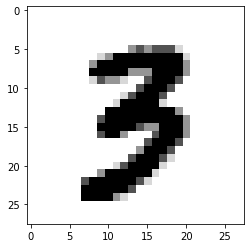

In [ ]:
#학습된 모델로 테스트세트 평가하기
with torch.no_grad(): #라고 하면 gradient 계산을 하지 않음
  X_test = mnist_test.test_data.view(-1, 784).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  prediction = linear(X_test)
  correct_prediction = torch.argmax(prediction, 1) == Y_test # torch.argmax(data, dim) dim을 기준으로 data에서 가장 큰 값의 인덱스를 텐서로 추출함.
                                                                              #예를들어 [[4, 5, 6, 9, 8], 라면 dim =1 인 경우에 tensor([4, 4, 3]) 이 되는 것 
                                                                              #             [1, 3, 4, 2, 6],
                                                                              #             [1, 5, 6, 8, -2]]  
                                                                              #(dim으로 보겠다는 거임. dim =1이면 열의 방향으로 보겠다는 거니까 같은 행 내에서의 최댓값의 인덱스가 되는것임.)
  accuracy = correct_prediction.float().mean()
  print("Accuray : ", accuracy.item())

  #테스트세트에서 무작위로 1개 뽑아서 예측해보기
  r = random.randint(0, len(mnist_test)-1)
  X_single_data = mnist_test.test_data[r:r+1].view(-1,784).float().to(device)
  Y_single_data = mnist_test.test_labels[r:r+1].to(device)

  print('Label : ', Y_single_data.item())
  single_predcition = linear(X_single_data)
  print('Prediction :' , torch.argmax(single_predcition, 1).item())
  plt.imshow(mnist_test.test_data[r:r+1].view(28,28), cmap = 'Greys', interpolation = 'nearest')
  plt.show()
